# 8. Deposit
The bombardment simulation is invoked using `fix deposit` command in LAMMPS.

## 8.1. Copy files

In [17]:
from pathlib import Path
from shutil import copy
cwd = Path.cwd()

source = cwd.parent/'7. Remap'
copy(source/'data.new.lmp', cwd/'data.lmp')

source = cwd.parent/'6. NVT'
copy(source/'CH.airebo', cwd)

'c:\\Users\\fitbe\\Desktop\\AO Tutorial\\LAMMPS\\8. Deposit\\CH.airebo'

## 8.2. Input file
Be careful, the name "AO" reminds us of doing atomic oxygen eorsion, but we are actually depositing atomic carbon.

In [28]:
%%writefile in.lmp
#-------------------- Initilization -------------------#
units metal
boundary p p f
atom_style charge

#-------------------- Structure -------------------#
read_data data.lmp

# Change simulation box
variable zhi equal zhi
variable zhi0 equal ${zhi}
variable zhi_delta equal 15
change_box all z delta 0 ${zhi_delta} boundary p p fm

#-------------------- Force Field -------------------#
pair_style airebo 3.0
pair_coeff * * CH.airebo C H C H

#-------------------- Simulation -------------------#
# Timestep
timestep 0.0001                                     # 0.1 fs
variable thermo equal ${AO_interval}                # Thermo data every ps
variable dump equal ${AO_interval}                  # Dump frames every ps
variable Nthermo equal ${thermo}/dt                 # Thermo steps
variable Ndump equal ${dump}/dt                     # Dump steps

# AO settings                
variable AO_vz equal -74                            # 74 Å/ps = 7.4 km/s
variable AO_above equal 14.8                        # Å above the surface
variable AO_freq equal ${AO_interval}/dt            # AO frequency
variable AO_run equal ${AO_freq}*${AO_num}
variable AO_zhi equal ${zhi0}+${AO_above}
region rAO block EDGE EDGE EDGE EDGE ${AO_zhi} ${AO_zhi}

# AO
variable isAO atom type==3                          # New AO atoms
group AO dynamic all var isAO every 1
variable AO_depth equal bound(AO,zmin)

# Compute
compute temp all temp
compute_modify temp dynamic/dof yes                 # Temperature is corrected because a new atom is added each time interval
 
# Thermo
thermo ${Nthermo}
thermo_style custom step time pe c_temp v_AO_depth
thermo_modify flush yes

# Dump
dump 1 all custom ${Ndump} dump.lmp id type element mass x y z vx vy vz
dump_modify 1 element C H C H

#-------------------- AO -------------------#
fix AO all deposit ${AO_num} 3 ${AO_freq} 12345 region rAO vz ${AO_vz} ${AO_vz} near 2
fix nve all nve
fix wall all wall/reflect zlo EDGE                  # Reflective wall
run ${AO_run}

#-------------------- End -------------------#
write_data data.new.lmp

Overwriting in.lmp


We despoit 50 atomic carbon and each is inserted every 0.1 ps.

In [33]:
!lmp -i in.lmp -l log.lmp -v AO_interval 0.1 -v AO_num 50

LAMMPS (2 Aug 2023 - Update 3)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Loaded 1 plugins from C:\Users\fitbe\AppData\Local\LAMMPS 64-bit 2Aug2023 with GUI\plugins
Reading data file ...
  orthogonal box = (0 0 0) to (28.047698 28.047698 35.607284)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  1860 atoms
  reading velocities ...
  1860 velocities
  read_data CPU = 0.012 seconds
Changing box ...
  orthogonal box = (0 0 0) to (28.047698 28.047698 50.607284)
Reading airebo potential file CH.airebo with DATE: 2011-10-25
dynamic group AO defined
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 12.2
  ghost atom cutoff = 12.2
  binsize = 6.1, bins = 5 5 9
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair airebo, perpetual
      attributes: full, newton on, ghost
      pair build: ful

# 8.3. Log file

In [2]:
# Import packages
from lammps.formats import LogFile
import pandas as pd

In [3]:
# Load log file
file = LogFile(filename='log.lmp')

# The file contains a list of runs and errors. We only have one run.
# Each run is a dictionary with thermo fields as keys, storing the values over time.
run = file.runs[0]

# Convert to pandas DataFrame
log = pd.DataFrame(run)

# Print
log

Step  Time     PotEng     c_temp    v_AO_depth
0       0.0   0.0 -7758.2589  293.80840  1.000000e+20
1    1000.0   0.1 -7761.3926  320.85384  4.301468e+01
2    2000.0   0.2 -7758.8264  324.18822  3.560954e+01
3    3000.0   0.3 -7757.4492  332.45412  3.258273e+01
4    4000.0   0.4 -7757.2437  345.58002  2.831829e+01
5    5000.0   0.5 -7755.8674  353.82663  2.766274e+01
6    6000.0   0.6 -7754.0612  360.28618  2.494711e+01
7    7000.0   0.7 -7751.7730  364.73726  2.505012e+01
8    8000.0   0.8 -7750.7324  374.35348  2.469626e+01
9    9000.0   0.9 -7750.3223  386.56365  2.424623e+01
10  10000.0   1.0 -7748.2496  391.89511  2.364245e+01
11  11000.0   1.1 -7744.1865  388.97043  2.343400e+01
12  12000.0   1.2 -7746.9480  414.27198  2.318502e+01
13  13000.0   1.3 -7743.4648  413.74034  2.134858e+01
14  14000.0   1.4 -7741.9128  421.18151  1.750000e+01
15  15000.0   1.5 -7739.8739  426.60984  1.751527e+01
16  16000.0   1.6 -7738.0406  432.88475  1.767144e+01
17  17000.0   1.7 -7736.9806  442.33918  1.709222e+01
18  18000.0   1.8 -7734.3160  445.16728  1.626357e+01
19  19000.0   1.9 -7735.6284  464.37557  1.550305e+01
20  20000.0   2.0 -7731.0491  459.29859  1.484753e+01
21  21000.0   2.1 -7730.1529  469.40243  1.429593e+01
22  22000.0   2.2 -7728.8969  477.98535  1.322872e+01
23  23000.0   2.3 -7727.8688  487.52006  1.286468e+01
24  24000.0   2.4 -7727.3744  499.26066  1.349513e+01
25  25000.0   2.5 -7721.9640  490.78572  1.354779e+01
26  26000.0   2.6 -7722.0936  505.06066  1.283083e+01
27  27000.0   2.7 -7714.8160  489.05785  1.234014e+01
28  28000.0   2.8 -7715.1131  504.00667  1.163915e+01
29  29000.0   2.9 -7714.2683  514.22242  1.106515e+01
30  30000.0   3.0 -7714.2672  527.80618  1.095434e+01
31  31000.0   3.1 -7715.0341  544.62007  1.075799e+01
32  32000.0   3.2 -7717.4677  568.28174  1.098205e+01
33  33000.0   3.3 -7710.2533  552.45037  1.108151e+01
34  34000.0   3.4 -7706.8680  552.20752  1.077124e+01
35  35000.0   3.5 -7706.6202  564.83047  1.109581e+01
36  36000.0   3.6 -7705.1745  572.57126  1.104013e+01
37  37000.0   3.7 -7702.4743  575.15321  1.027105e+01
38  38000.0   3.8 -7706.3082  604.44310  1.019947e+01
39  39000.0   3.9 -7705.4113  614.39937  1.068773e+01
40  40000.0   4.0 -7708.7413  641.58896  1.149746e+01
41  41000.0   4.1 -7703.7548  634.80065  1.177879e+01
42  42000.0   4.2 -7700.3192  634.33229  1.153128e+01
43  43000.0   4.3 -7702.8860  658.34308  1.138138e+01
44  44000.0   4.4 -7696.6004  646.26707  1.044726e+01
45  45000.0   4.5 -7696.3758  658.86110  1.073976e+01
46  46000.0   4.6 -7697.3492  676.32605  1.139512e+01
47  47000.0   4.7 -7692.7245  671.06412  1.133367e+01
48  48000.0   4.8 -7690.1489  674.07227  1.064609e+01
49  49000.0   4.9 -7693.3165  700.34516  1.056403e+01
50  50000.0   5.0 -7689.1131  696.75314  1.025978e+01

<Axes: xlabel='No. of AO', ylabel='Temperature (K)'>

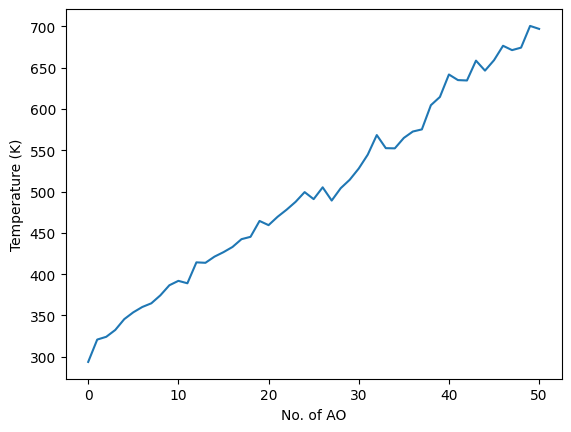

In [4]:
# Plot the temperature
log['AO'] = log.index
log.plot(x='AO', y='c_temp', xlabel='No. of AO', ylabel='Temperature (K)', legend=False)

In [10]:
# Plot the AO depth
log.loc[0, 'v_AO_depth'] = 0        # Zero the depth for the initial frame
log.plot(x='AO', y='v_AO_depth', xlabel='No. of AO', ylabel='Depth (Å)', legend=False)

<Axes: xlabel='No. of AO', ylabel='Depth (Å)'>